In [102]:
import pylcp
import numpy as np
from matplotlib import pyplot as plt
from scipy import constants as const
from sympy.physics.wigner import wigner_3j, wigner_6j, wigner_9j
import time
import pathos
from sympy import Symbol
import numbers
from scipy.optimize import bisect
from cmcrameri import cm as scicmap
import matplotlib.colors as mcolors

In [103]:
labels = [(1,1),(2,2),(3,3)]
fulllabels = np.concatenate([[(l[0],l[1],i) for i in np.arange(-l[1],l[1]+1)] for l in labels])

In [104]:
def AState_mu_q1(J, lbls, I1, I2): # for the A1Pi state
    def matrix_element(p,F1,F,MF,F1p,Fp,MFp):
        return float((-1)**(F-MF+F1p+F+I2+1+J+F1+I1+1+J-1)*np.sqrt((2*F+1)*(2*Fp+1)*(2*F1+1)*(2*F1p+1)*(2*J+1)*(2*J+1))*wigner_3j(F,1,Fp,-MF,p,MFp)*wigner_3j(J,1,J,-1,0,1)*wigner_6j(F1p,Fp,I2,F,F1,1)*wigner_6j(J,F1p,I1,F1,J,1))
    return np.array([[[matrix_element(i,*l1,*l2) for l2 in lbls] for l1 in lbls] for i in [-1,0,1]])

In [105]:
muq = AState_mu_q1(1,fulllabels,2,0)

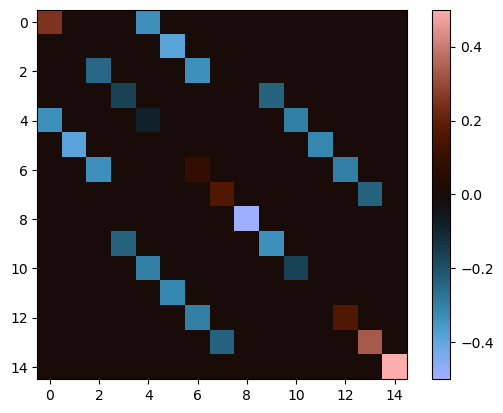

In [106]:
plt.imshow(muq[1],cmap=scicmap.berlin,norm=mcolors.CenteredNorm(0))
plt.colorbar()

In [107]:
def Q_d_q(J, exlabels, grlabels, I1, I2):
    def matrix_element(p,F1,F,MF,F1p,Fp,MFp):
        return float((-1)**(F-MF)*wigner_3j(F,1,Fp,-MF,p,MFp)*np.sqrt(3*(2*F+1)*(2*Fp+1))*wigner_9j(F,Fp,1,F1,F1p,1,I2,I2,0)*np.sqrt(3*(2*F1+1)*(2*F1p+1))*wigner_9j(F1,F1p,1,J,J,1,I1,I1,0))
    raw_dq =  np.array([[[matrix_element(i,*l1,*l2) for l2 in exlabels] for l1 in grlabels] for i in [-1,0,1]])
    norm = np.sqrt(np.sum(np.abs(raw_dq)**2,axis=(0,1)))
    return np.einsum("ijk,k->ijk",raw_dq,1/norm)

In [108]:
dq = Q_d_q(1,fulllabels,fulllabels,2,0)

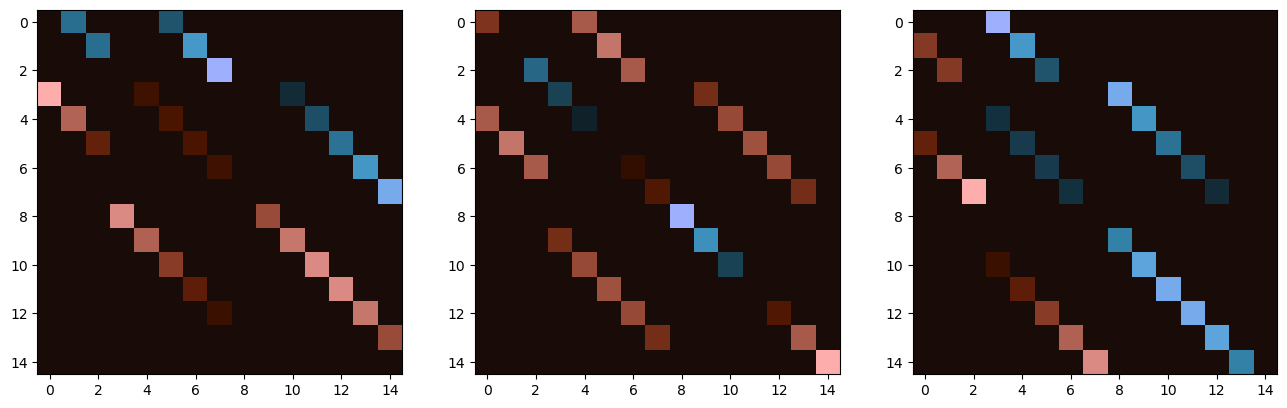

In [109]:
fig, axs1 = plt.subplots(1,3,figsize=[16,12])
[axs1[i].imshow(dq[i],cmap=scicmap.berlin,norm=mcolors.CenteredNorm(0)) for i in range(3)]

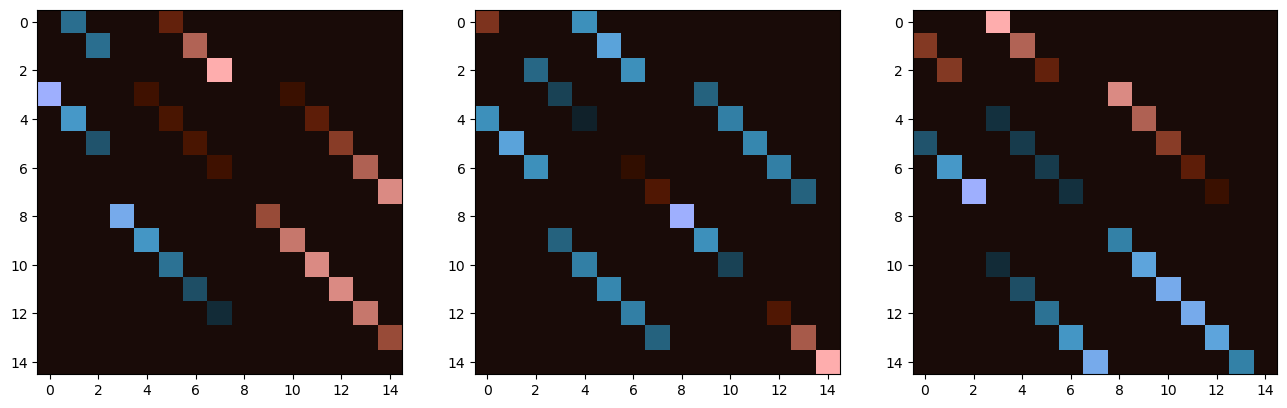

In [110]:
fig, axs1 = plt.subplots(1,3,figsize=[16,12])
[axs1[i].imshow(muq[i],cmap=scicmap.berlin,norm=mcolors.CenteredNorm(0)) for i in range(3)]

In [120]:
H0g = np.zeros((15,15))
H0e = np.diag(np.concatenate([[-2]*3,[0]*5,[2]*7]))
muqg = np.zeros((3,15,15))

In [121]:
hamiltonian = pylcp.hamiltonian(H0g,H0e,muqg,muq,dq)

In [122]:
def MOT_Beams(s, delta, wb, p):
    return pylcp.laserBeams([
        {'kvec':np.array([-1/np.sqrt(2), -1/np.sqrt(2), 0.]), 'pol':p, 'delta':delta, 's':s},
        {'kvec':np.array([1/np.sqrt(2), 1/np.sqrt(2), 0.]), 'pol':p, 'delta':delta, 's':s},
        {'kvec':np.array([1/np.sqrt(2), -1/np.sqrt(2), 0.]), 'pol':p, 'delta':delta, 's':s},
        {'kvec':np.array([-1/np.sqrt(2), 1/np.sqrt(2), 0.]), 'pol':p, 'delta':delta, 's':s},
        {'kvec':np.array([0., 0.,  1.]), 'pol':-p, 'delta':delta, 's':s},
        {'kvec':np.array([0., 0., -1.]), 'pol':-p, 'delta':delta, 's':s},
    ], beam_type=pylcp.infinitePlaneWaveBeam)

In [123]:
mag_field = pylcp.fields.quadrupoleMagneticField(1)

In [135]:
rateeq = pylcp.rateeq(MOT_Beams(s=1,delta = -3, p=1, wb=0.5), mag_field, hamiltonian,include_mag_forces=False)
r = np.linspace(-20, 20, 80)
v = np.linspace(-8, 8, 100)

R, V = np.meshgrid(r, v)
rateeq.generate_force_profile([R, np.zeros(R.shape), np.zeros(R.shape)],
                           [V, np.zeros(V.shape), np.zeros(V.shape)],
                           name='Frad', progress_bar=True)

Fprofile = rateeq.profile['Frad'].F[0]
Fprofile[np.isnan(Fprofile)] = 0


Completed in 8.09 s.                                               


(-20.0, 20.0)

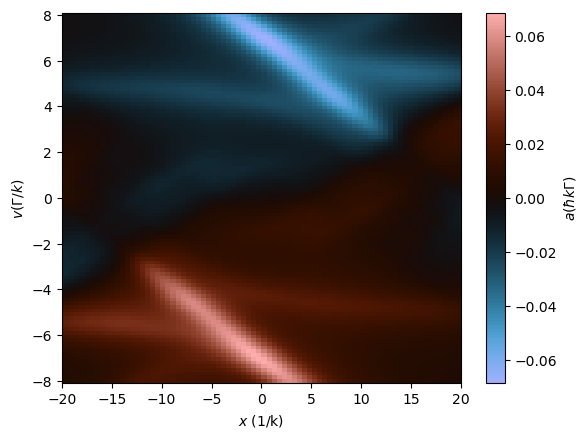

In [136]:
fig, ax = plt.subplots(1, 1)
colormesh = ax.pcolormesh(R, V, Fprofile, cmap = scicmap.berlin, norm=mcolors.CenteredNorm(0))
cb1 = plt.colorbar(colormesh)
cb1.set_label('$a(\\hbar k \\Gamma)$')
ax.set_xlabel('$x$ (1/k)')
ax.set_ylabel('$v(\\Gamma/k)$')
fig.subplots_adjust(left=0.12,right=0.9)
ax.set_xlim([-20,20])
# ax.set_ylim([-8,8])

In [126]:
det = -1.5
R = np.linspace(-20, 20, 160)
v = np.linspace(-150, 150, 600)

dets = np.linspace(-4,4,40)
sols = []
for det in dets:
   print(det,end='\r')
   rateeq = pylcp.rateeq(MOT_Beams(s=1,delta = det, p=1,wb=0), mag_field, hamiltonian,include_mag_forces=False)
   rateeq.generate_force_profile([R,np.zeros(R.shape),np.zeros(R.shape)],
                              [np.zeros(R.shape),np.zeros(R.shape),np.zeros(R.shape)],
                           name='Frad', progress_bar=False)
   sols.append(rateeq.profile['Frad'].F[0])
   
RR, DD = np.meshgrid(R,dets)


In [127]:
Es = np.unique(np.diag(H0e))

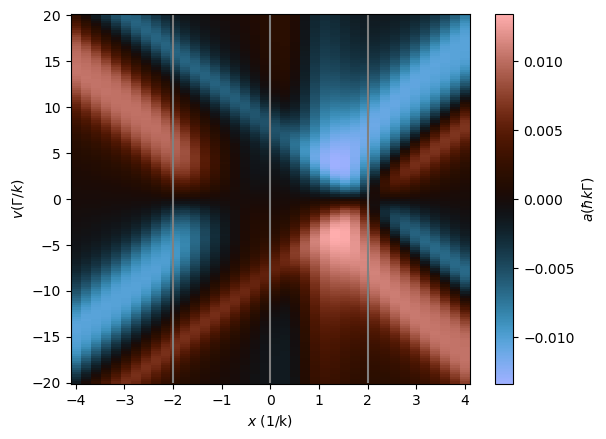

In [129]:
fig, ax = plt.subplots(1, 1)

# colormesh = ax.plot(R*cm_unit*10, rateeq.profile['Frad'].F[0]*F_unit*1e-3/(46*1.66e-27))
colormesh = ax.pcolormesh(DD,RR,np.asarray(sols),cmap=scicmap.berlin,norm = mcolors.CenteredNorm(0))
cb1 = plt.colorbar(colormesh)
cb1.set_label('$a(\\hbar k \\Gamma)$')
ax.set_xlabel('$x$ (1/k)')
ax.set_ylabel('$v(\\Gamma/k)$')
ylim = ax.get_ylim()
# ax.xlim(-20,20)
# ax.grid()
ax.vlines(Es,-20,20,colors=['gray']*len(Es))
# ax.vlines(Es+0.07159447,-2,2,colors=['w']*len(Es))
# ax.vlines(Es-0.06259833,-2,2,colors=['g']*len(Es))
fig.subplots_adjust(left=0.12,right=0.9)